# Oblivious transfer

Как Diffie-Helman exchange, но для нескольких секретов. Использует public-key cryptography.

Alice не знает что Bob запросил, Bob получает все записи (сообщения), но может расшифровать только ту что запросил

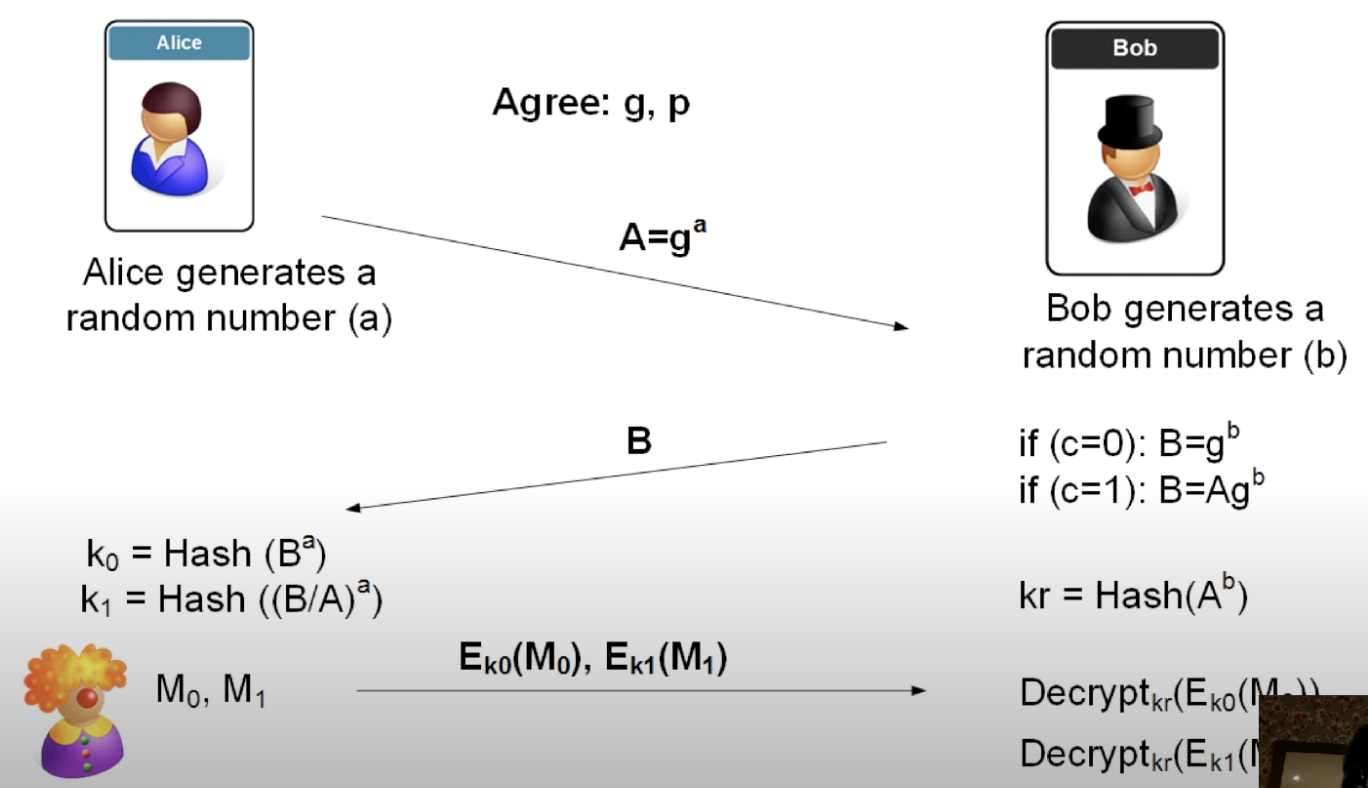

# Garbled (hidden) circuits

## Yao's garbled circuits

* Number of communication rounds does not depend on circuit depth
* **Circuit evaluation can happen with little to none communication** (ideal for settings in which the parties are widely distributed and latency is high)
* Only usefull for boolean circuits (>,<,=)
* Works only for two parties (extension possible)

We wish to evaluate function $F(x_1, x_2)$ where party $P_1$ holds $x_1$ and party $P_2$ holds $x_2$

### Preprocessing
1) Boolean gate as a lookup table $T_{{x_1},{x_2}} = F(x_1,x_2)$
    * $P_1$ will encrypt $T$ by assigning a randomly-chosen strong key to each possible input $x_1$ and $x_2$, namely $k_{x_1}$ and $k_{x_2}$ (4 keys total)
    * Send encrypted table $Enc_{k_{x_1},k_{x_2}}(T_{x_1,x_2})$ to $P_2$, each row of the table is encrypted with *both* keys $k_{x_1}$ and $k_{x_2}$
    * Send $k_{x_1}$ in plain text
    * Send $k_{x_2}$ to $P_2$ using 1-out-of-$|X_2|$ oblivious transfer, so that $P_2$ learns only corresponding $x_2$
    * $P_2$ can decrypt only the entry $T_{x_1,x_2}$ corresponding to $P_2$ input
3) Represent $F$ as a boolean circuit $C$ with gates of size 4
    * <mark>Cannot reveal</mark> the plaintext output of intermediate gates
    * For each wire $w_i$ of $C$, $P_1$ assigns two keys $k^0_i$ and $k^1_i$, corresponding to two possible values on the wire, which we will call _wire labels_
    * $P_1$ sends all tables to $P_2$
    * $P_1$ sends(only) the active labels of all wires corresponding to the input values to $P_2$. So evaluator can know only the active label, but not its corresponding plaintext value, and not the inactive label
    * Each cell of the look-up table **encrypts the <mark>label</mark> corresponding to the output computed by the gate**. For each gate $P_1$ builds:
      $$
      \begin{bmatrix}
           Enc_{k^0_i, k^0_j} (k^{G(0,0)}_t) \\
           Enc_{k^0_i, k^1_j} (k^{G(0,1)}_t) \\
           Enc_{k^1_i, k^0_j} (k^{G(1,0)}_t) \\
           Enc_{k^1_i, k^1_j} (k^{G(1,1)}_t)
      \end{bmatrix}
      $$
    * $P_2$ can <mark>decrypt</mark> only the entry with keys $k_i, k_j$ he knows

For example, if $G$ is an `AND` gate:

\begin{bmatrix}
           Enc_{k^0_i, k^0_j} (k^0_t) \\
           Enc_{k^0_i, k^1_j} (k^0_t) \\
           Enc_{k^1_i, k^0_j} (k^0_t) \\
           Enc_{k^1_i, k^1_j} (k^1_t)
\end{bmatrix}


## BGW (Ben-Or, Goldwasser, and Wigderson) protocoll

The players hold additive shares of the active wire value.

* Arithmetic circuit over a field F, consisting of **addition**, **multiplication**, and **multiplication-by-constant** gates
* Based on Shamir secret sharing

### Construction

#### Brief
* A dealer chooses a random polynomial $p$ of degree at most $t$, such that $p(0) = \nu$
* Each party $P_i$ holds value $p(i)$ as their share
* For every wire $w$ in the arithmetic circuit, the parties hold a secret-sharing $[v_w]$ of the value $v_w$ on that wire.

#### Input wires
For an input wire belonging to party $P_i$, that party knows the value $\nu$ on that wire in the clear, and distributes shares of $\nu$ to all the parties

#### Addition gate
Given input wires $\alpha$, $\beta$ and output wire $\gamma$. The parties collectively hold sharings of incoming wires $\nu_\alpha$ and $\nu_\beta$ and the goal is to obtain a sharing of $[\nu_\alpha+\nu_\beta]$.
Each party $P_i$ locally adds their shares $p_\alpha(i)+p_\beta(i)$ then $p_\gamma(i)=p_\alpha(i)+p_\beta(i)$ so $p_\gamma(0)=p_\alpha(0)+p_\beta(0)=\nu_\alpha+\nu_\beta$

#### Multiplication gate
The goal is to obtain a sharing of the product $[\nu_\alpha*\nu_\beta]$. Each party $P_i$ locally computes $q(i)=p_\alpha(i)*p_\beta(i)$. The resulting polynomial may have degree as high as $2t$, which is too high.

$q(0) = \sum\limits_{i=1}^{2t+1} \lambda_i q(i)$ - linear function of party's shares, where $\lambda_i$ are Lagrange coefficients

Degree reduction step:
1) Each party $P_i$ generates and **distributes** a threshold-t sharing $[q(i)]$ where $q$ is a polynomial of degree at most $t$ **whose constant coefficient is $q(i)$**
2) The parties compute $[q(0)]=\sum\limits_{i=1}^{2t+1} \lambda_i [q(i)]$ locally. Note that the expression is in terms of addition and multiplication-by constant applied to secret-shared values

Since the values $[q(i)]$ were shared with threshold $t$, the final sharing of $[q(0)]$ also has a threshold $t$ as desired.

#### Output wires
Each party broadcasts its output share to reconstruct output coefficient $p(0) = \nu$

#### Note!
* BGW requires communication/interaction in the form of parties sending shares of $[q(i)]$
* Require $2t+1\le n$ - secure for honest majority by default

## MPC From Preprocessed Multiplication Triples

Split problem into **pre-processing** (before inputs are known) and **online** (after inputs are chosen) phase.

### Beaver triple

**Idea**: move the majority of the communication to the pre-processing phase (e.g. enhance multiplication gate in BGW). 

**Def**: $a$ and $b$ are randomly chosen from the appropriate field, and $c=ab$

One Beaver triple is then "consumed" for each multiplication gate in the eventual protocol. The paradigm is also secure in the presence of malicious adversaries.

Consider multiplication gate with input wires $\alpha$, $\beta$. The parties hold secret sharings of $[\nu_\alpha]$ and $[\nu_\beta]$. To get $[\nu_\alpha]*[\nu_\beta]$ do:
1) Locally compute $[\nu_\alpha - a]$ and publicly open $d = \nu_\alpha - a$ - reveals no information about secret $\nu_\alpha$
2) Locally compute $[\nu_\beta - b]$ and publicly open $e = \nu_\beta - b$
3) $\nu_\alpha\nu_\beta=de+db+ea+c$ so using only local computations get $[\nu_\alpha\nu_\beta]=de+d[b]+e[a]+[c]$

Each party must broadcast two field elements per multiplication, compared to $n$ field elements (across private channels) in the plain BGW protocol.

# Linear secret sharing scheems

## Shamir

Secure if $t<n/2$

$\mathbb{F}$ - a field of size $q$, where $q$ is a power of a prime.
Let $\alpha_1, ... \alpha_n$ be different points in $\mathbb{F}$

* The dealer samples a polynomial $f(X) \in \mathbb{F}_{\le d}[X]$, $f(X)=s + \sum\limits_{i=1}^d c_iX^i$
* $f(\alpha_0) = s$, whre $s$ is a secret
* The share corresponding to party $P_i$ is $f(\alpha_i)$

#### Reconstruction of a secret
Is done using Lagrange coefficients. Given $d+1$ shares we can fully reconstruct a polinomial $f(X)$, then $s = f(0)$

#### Error detection/correction
We could ask $t+1$ parties to send their shares to reconstruct a secret, but if parties are corrupt (active) they could send false shares and the resulting polinimial will be incorrect.

Error correction algorithms (decoders) exist, e.g. **Berlekamp-Welch algorithm**. Possible if $n>d+2t$

Alice wants to send Bob a message of length $d$ characters. However, an adversary Eve, is allowed to corrupt any of up to $t$ of the packets (characters).

#### Proposition
By transmitting d + 2t packets, Alice will be able to guard against up to $t$ general
errors (corruptions) and Bob can recover Alice’s messag.e 

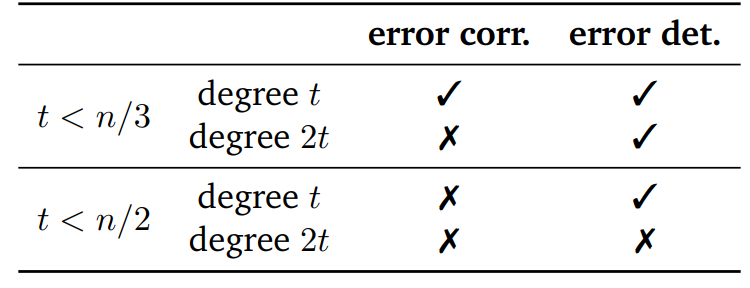

## Passive and perfect security for honest majority

Perfectly secure protocol that is secure against a passive adversary corrupting t parties where $t < n/2$

### Passively secure protocol with perfect security
No need for error correction (passive).

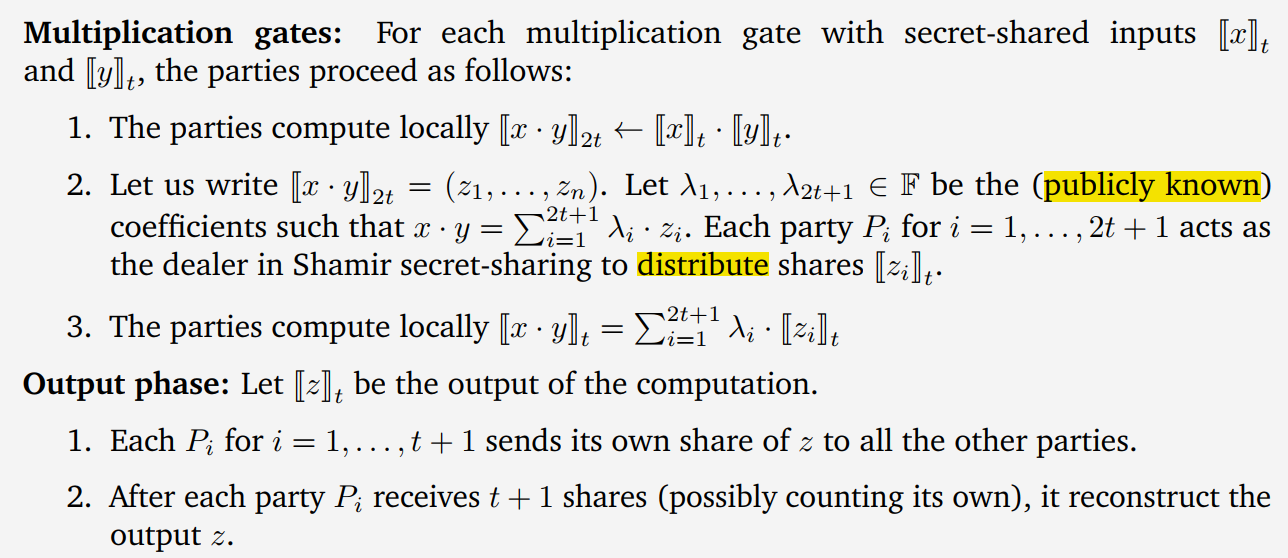

**Communication complexity:** $(2t+1)*n$ - each party from $2t+1$ set sends $z_i$ to every party $P_i$ for $i \in [1,n]$

На индексах $i=1,...,n$ берутся точки $z(i)=x(i)y(i)$
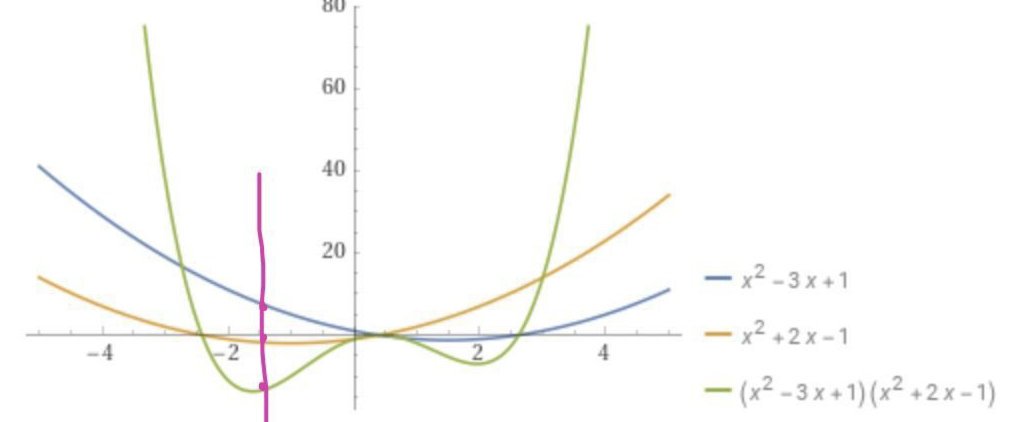

### Secure multiplication protocol via double-sharings
Double sharing is a pair $([r]_t, [r]_{2t})$ where $r \in \mathbb{F}$ is random and unknown to adversary. Double-sharings constitute preprocessing material.

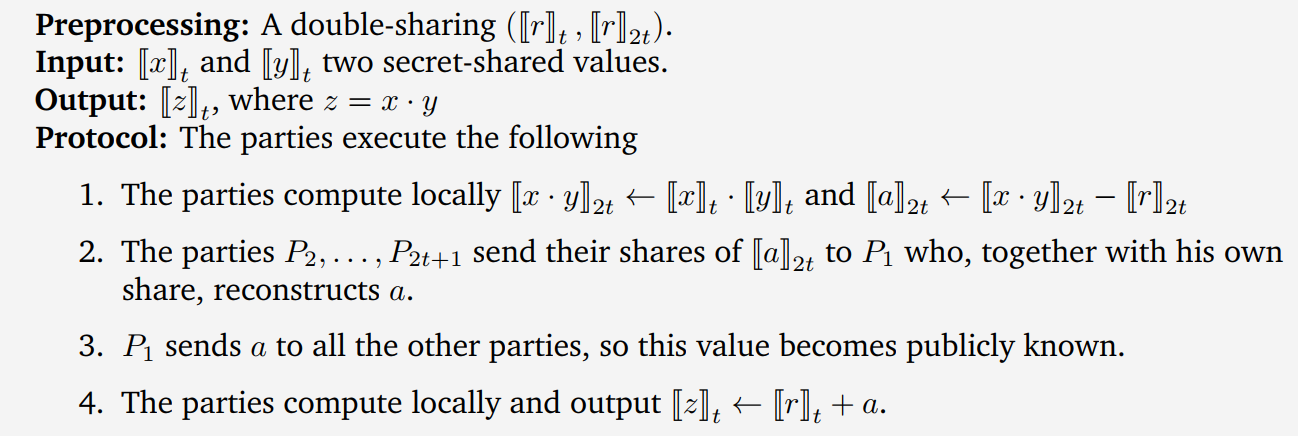

**Communication complexity:** $2t+n$ - linear complexity

**Preprocessing double shares**

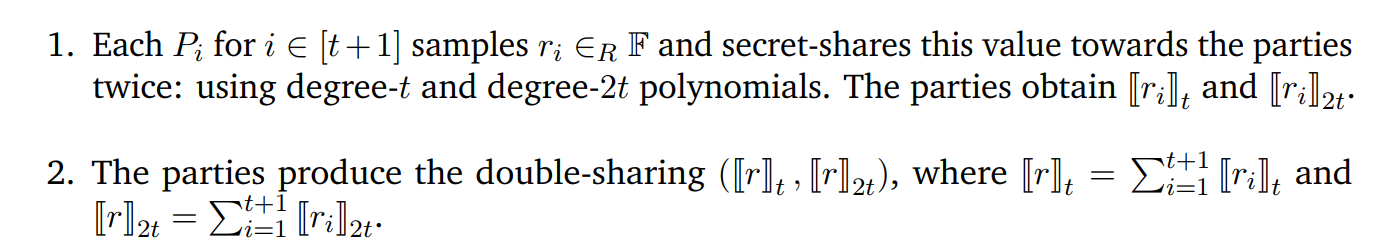

## Active and Perfect Security for Two-Thirds Honest Majority

Perfectly secure protocol that is secure against a active adversary corrupting t parties where $t < n/3$

### Actively secure input phase

How could each party distribute shares of its own input? Corrupt parties may distribute inconsistent shares

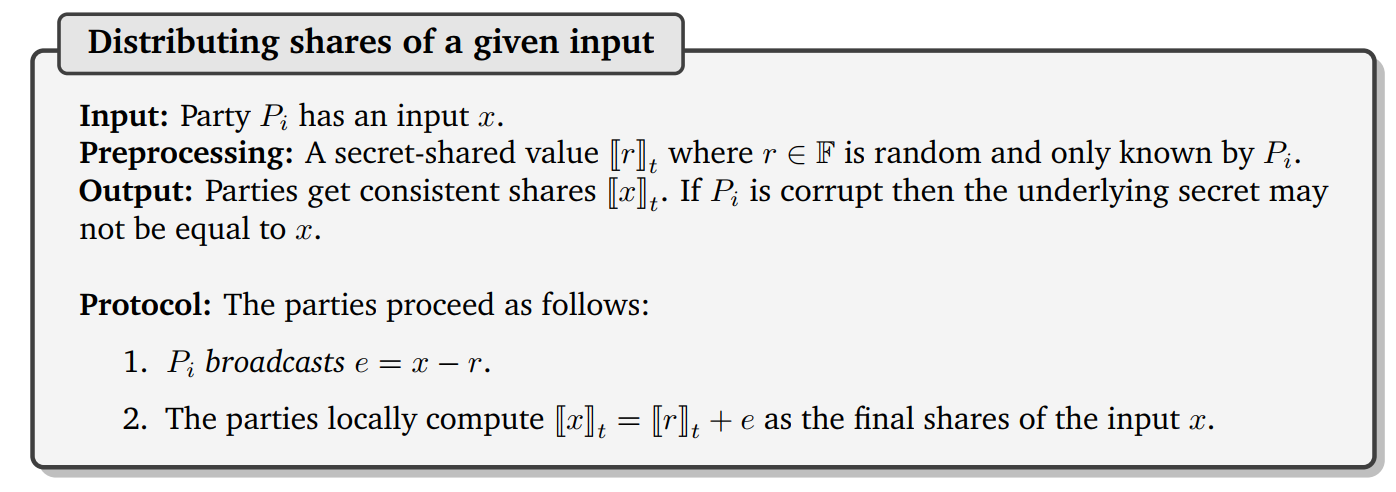

This is better than sending $[x]_t$ to each party because:
1) $e$ is publicly know, $P_i$ can't send different value to different parties
2) broadcast is more efficient than unicast, no need for private channel

## Active and Statistical Security for Honest Majority

$t<n/2$

Adversary can inject certain errors in the online phase that may cause the computation to be incorrect. This is dealt with by executing a check before the output phase to verify that no errors were introduced during the computation.

Example: If $n=3$ and $F(x_1,x_2,x_3) = (x_1 x_2)x_3$ a party $P_i$ is corrupt it could add a non-zero error $(x_1 x_2 + \delta)x_3 = F(x_1,x_2,x_3) + \delta x_3$ and  set $x_1=0$ so the correcrt output is always $0$ regardles of inputs and it gets $0+\delta x_3$. This means it now knows $x_3$

Let $F_{Coin}$ be a function that returns public random values to all the parties.

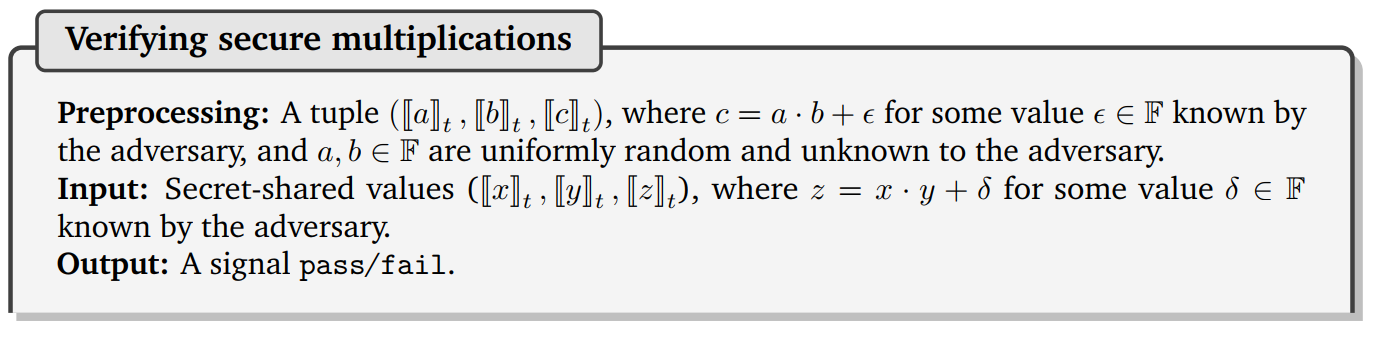
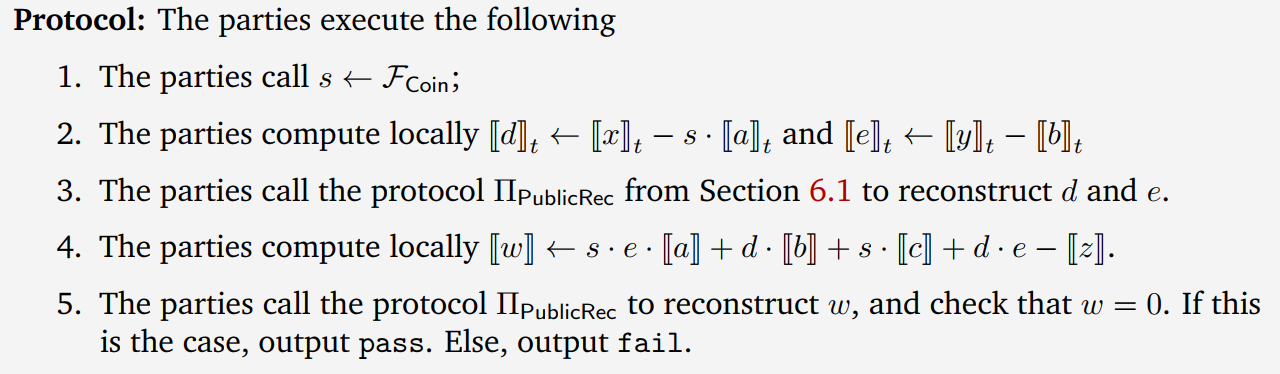

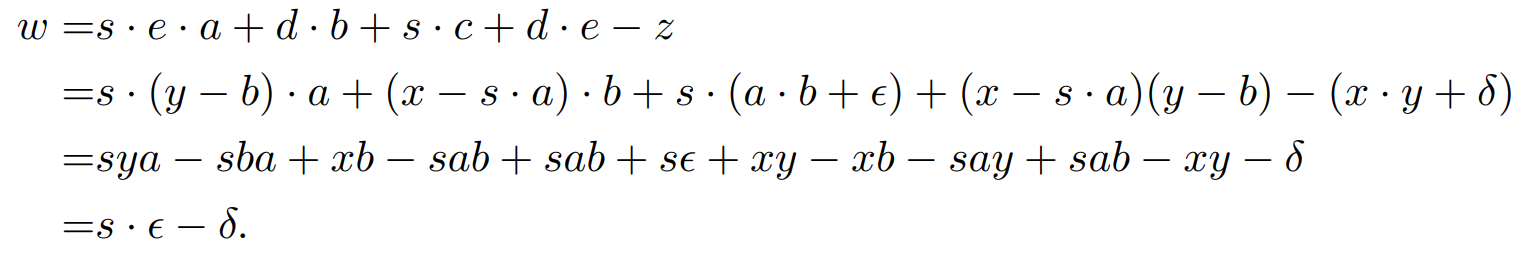

$w=0$ if $\epsilon=\delta=0$

## Passive Security for Dishonest Majority

$t<n$, dishonest majority, requires public-key cryptography

### Additive Secret-Sharing

Assume $t=n-1$

The dealer secret-shares a value $s \in \mathbb F$ among $n$ parties $P_1...P_n$ as follows
1) Sample $s_1...s_{n-1} \in \mathbb F$ and define $s_n = s-(s_1+\dots+s_{n-1})$
2) Distribute the value $s_i$ to party $P_i$ for $i \in [n]$

### Multiplication (Product-to-Sum Conversion)
Reduce the problem of obtaining $[xy]$ to a simpler problem. Write $[x]=(x_1,...,x_n)$ and $[y]=(y_1,...,y_n)$ so

$xy = (x_1+...+x_n)(y_1+...+y_n)= \sum\limits_{i=1}^n x_i y_i + \sum\limits_{i,j \in [n], i\ne j} x_i y_j$

The goal is to obtain shares of each of these summands.

* $x_i y_i$ is known by $P_i$, so $[x_i y_i]$ can be computed locally
* $x_i y_j$

  Assume the existance of a protocol for *product-to-sum* conversion, in which $P_i$ inputs $x_i$, $P_j$ inputs $y_j$, and $P_i$ and $P_j$ receive uniformly random $z_i$ and $z_j$ such that $x_i y_j = z_i + z_j$

So we get 

$[xy] = \sum\limits_{i=1}^n [x_i y_i] + \sum\limits_{i,j \in [n], i\ne j} [x_i y_j]$

#### Product-to-sum conversion based on homomorphic encryption

*Additively homomorphic encryption* scheme consists of an encryption and decryption algorithms $Enc_{pk}$ and $Dec_{sk}$ such that:
* $Enc_{pk}$ does not leak anything about message $m$
* If $c = Enc_{pk}(m)$ then $m=Dec_{sk}(c)$
* If $c=Enc_k(x)$ and $d=Enc_k(y)$ then $c \pm d = Enc_k(x \pm y)$

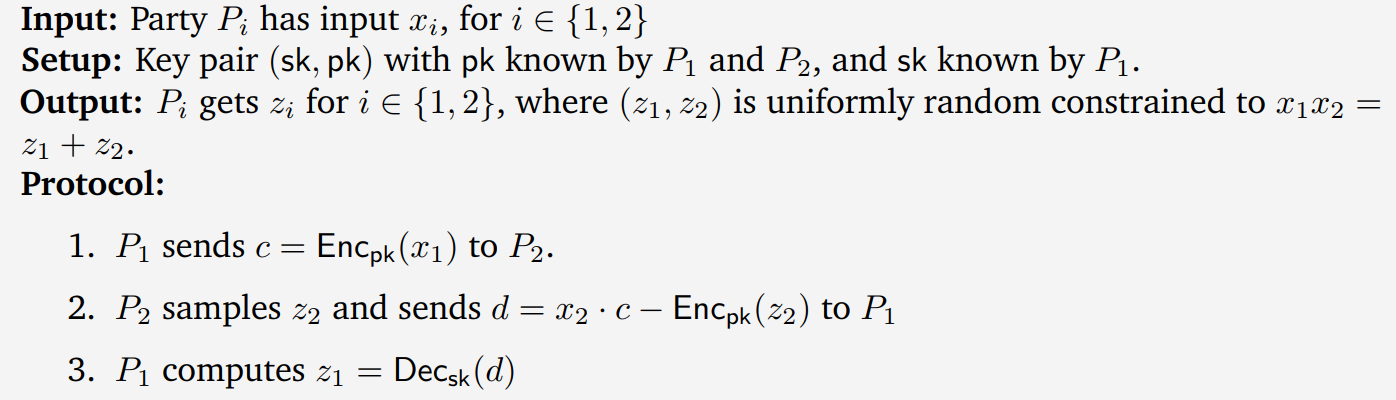

So $z_1 = x_1 x_2 - z_2$

### Offline Phase

To accelerate the computation of secure multiplications in the online phase, the parties  will need to produce a set of Beaver triples.

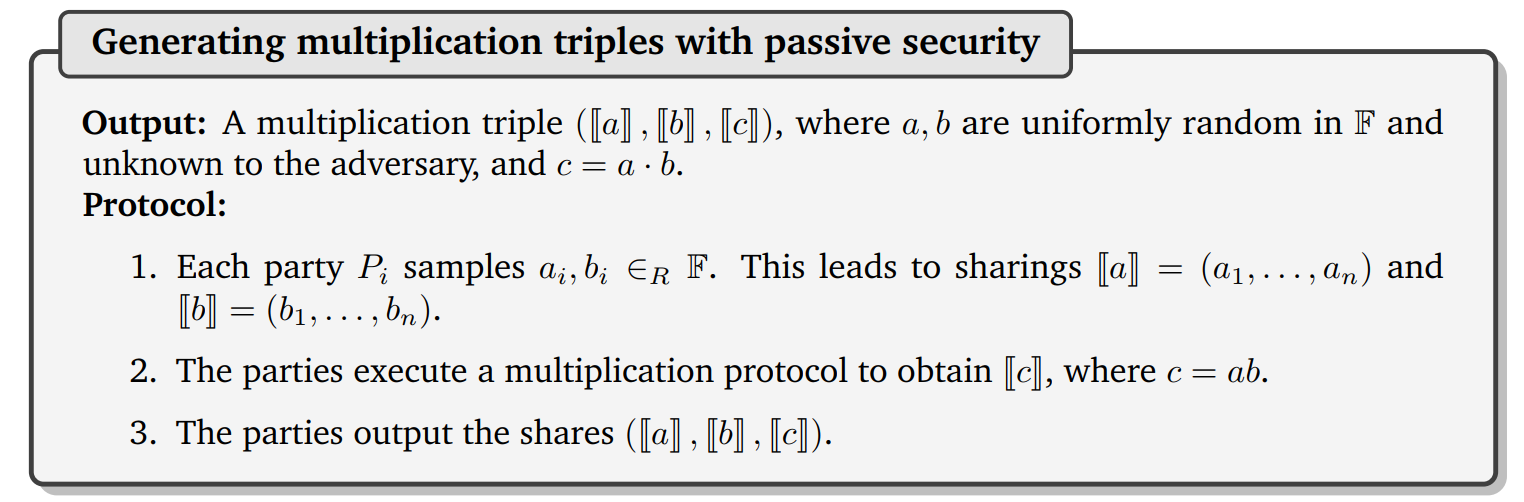

**Note:** Homomorphic encryption is used only in offline phase!

### Online Phase

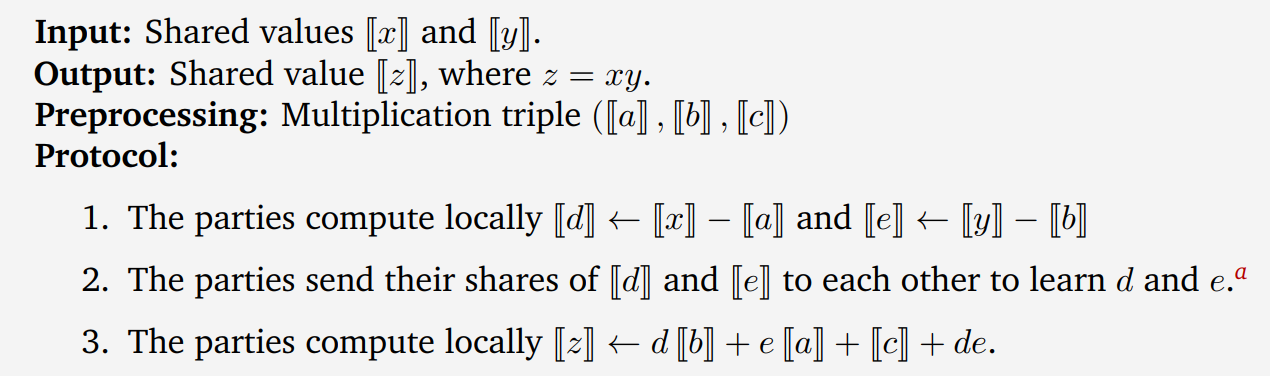

## Active Security for Dishonest Majority

$t<n$ with active adversary

In passive case at reconstruction time a corrupt party $P_i$ can change their share from $x_i$ to $x_i + \delta_i$ for some $\delta_i \in \mathbb F$. And there is no method for the honest party to detect this change.

The <mark>main idea</mark> is to add some redundant information to a given additively-shared value $[s] = (s_1,...,s_n)$ so that, when the parties <mark>announce</mark> their shares $(s^{\prime}_1,..., s^{\prime}_n)$, the parties can verify that the reconstructed value $s^{\prime} = s^{\prime}_1 + ... + s^{\prime}_n$ is indeed correct.

#### Message Authentication Codes 
*Message Authentication Codes* guarantees data integrity, that is, that an adversary cannot modify certain piece of data without being detected. MACs are used in order to authenticate the parties’ shares so that they cannot change them at a later point.

Given a piece of data $m \in \mathbb F$, compute a random value $\alpha \in \mathbb F$ and let $\tau = \alpha \cdot m$. Integrity is checked by veriying that $\tau = \alpha \cdot m$ holds. If $m$ is modified as $m^{\prime} = m + \delta$ and $\tau$ is modified as $\tau^{\prime} = \tau + \epsilon$, then this is possible iff $\alpha \cdot \delta=\epsilon$. If $\delta \ne 0$, that is if $m$ was indeed modified to a different $m^{\prime}$, then this equation translates to $\alpha = \epsilon/\delta$. If we guarantee that $\epsilon$ and $\delta$ are independent of $\alpha$, then, given $\alpha$ is uniformly random in $\mathbb F$, this equation can be satisfied with probability $1/|\mathbb F|$.

### Integrity via Pairwise MACs

Each party checks the share announced by each other party.

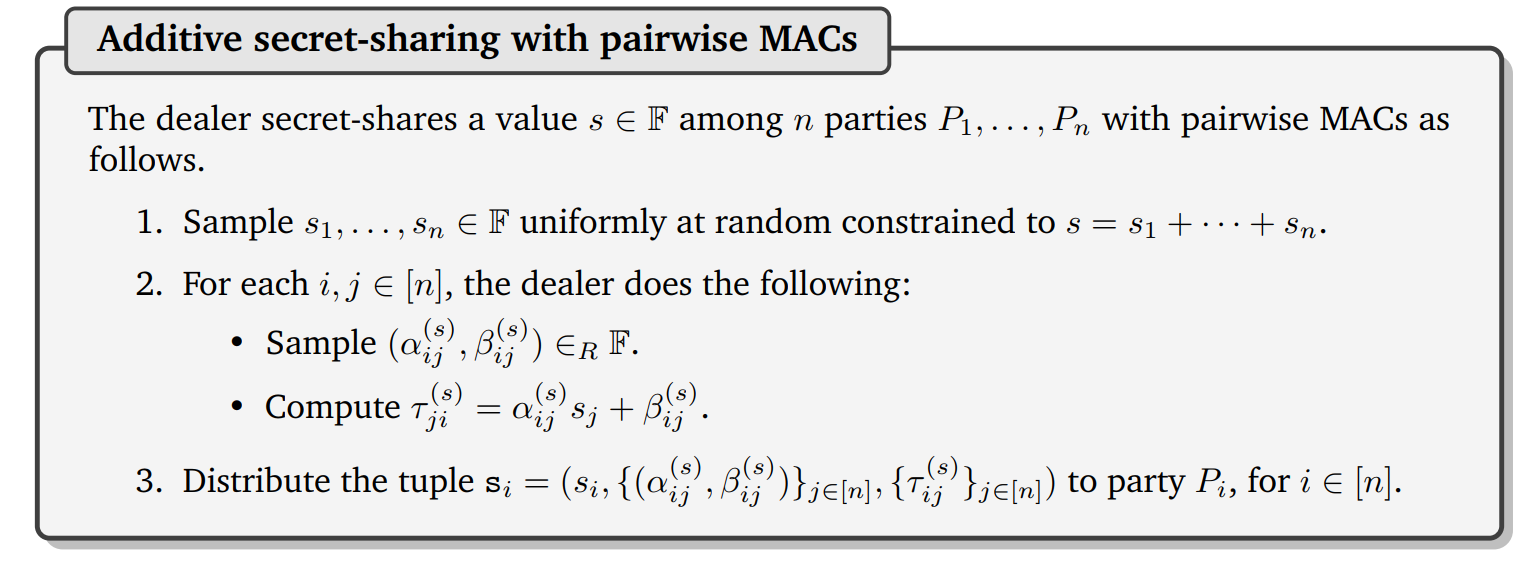

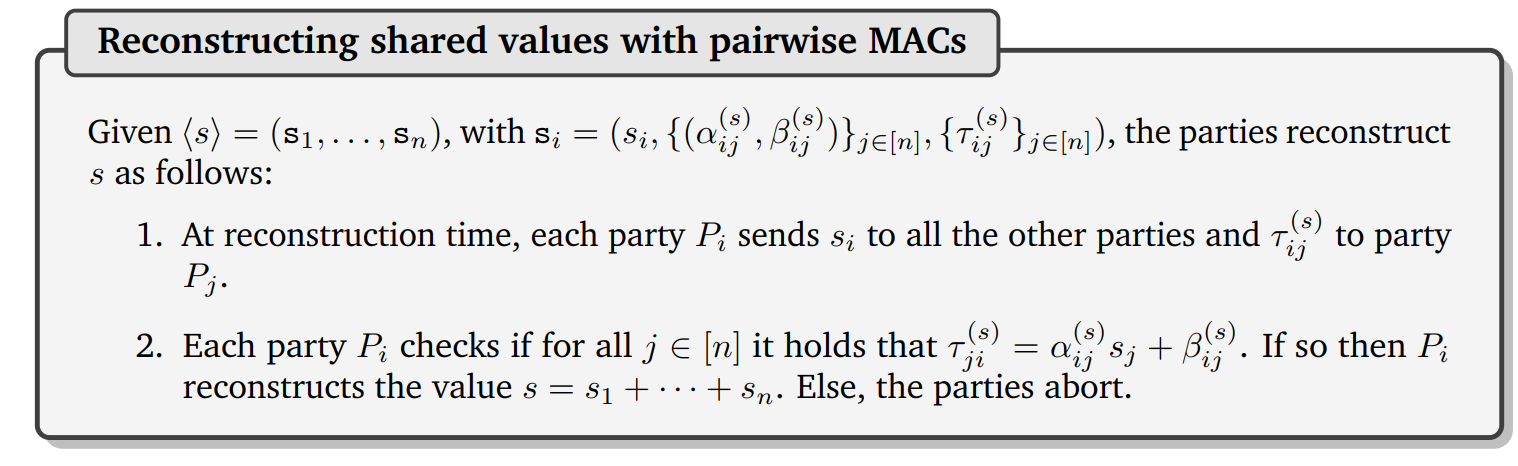

#### Addition

Assume we have two shares $\langle x \rangle = (\mathbf x_1,..., \mathbf x_n)$ and $\langle y \rangle = (\mathbf y_1,...,\mathbf y_n)$, with $\mathbf x_i = (x_i, \{(\alpha_{i,j}^{(x)}, \beta_{i,j}^{(x)})\}_{j \in [n]}, \{\tau_{i,j}^{(x)}\}_{j \in [n]})$ and $\mathbf y_i = (y_i, \{(\alpha_{i,j}^{(y)}, \beta_{i,j}^{(y)})\}_{j \in [n]}, \{\tau_{i,j}^{(y)}\}_{j \in [n]})$. To make the scheme compatible with local addition we need to sample <mark> $\alpha_{ij} := \alpha_{ij}^{(x)} = \alpha_{ij}^{(y)}$ </mark>

To obtain $\langle x+y \rangle$ each party defines $\mathbf z_i$ as $(z_i, \{(\alpha_{i,j}^{(z)}, \beta_{i,j}^{(z)})\}_{j \in [n]}, \{\tau_{i,j}^{(z)}\}_{j \in [n]})$ where:

$$
\begin{cases}
    z_i = x_i + y_i \\
    \beta_{i,j}^{(z)} = \beta_{i,j}^{(x)} + \beta_{i,j}^{(y)}, j \in [n] \\
    \tau_{i,j}^{(z)} = \tau_{i,j}^{(x)} + \tau_{i,j}^{(y)}, j \in [n]     
\end{cases}
$$

### Integrity via Global MACs

Pairwise MACs shares grow in size linearly with $n$, this could be fatal for large $n$. We intoduce here a different method that adds a small overhead to the size of each share. The core idea is to add integrity not to each individual share, but rather to the shared value $s$ itself.

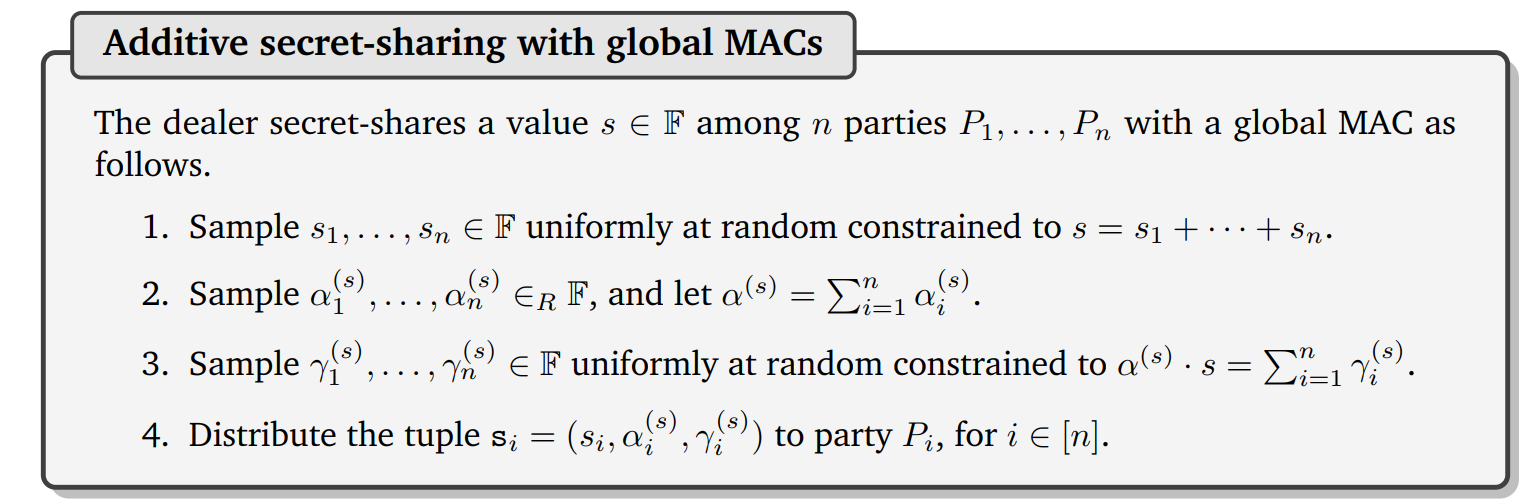

Notice that each party’s share is now made of **only 3 elements** in $\mathbb F$.

#### Reconstructing Secret-Shared Values

##### Partial opening
Assume parties have additive shares $\langle \mathrm s \rangle = (\mathrm s_1, ..., \mathrm s_n)$ of some value $s$. By partially opening we mean the following:
1) Each party $P_i$ sends their additive share $s_i$ of $[s]$ to $P_1$
2) $P_1$ computes $s = s_1 + ... + s_n$ and then he broadcasts $s$ to all parties

This basic opening does not ensure the correct value is reconstructed, hence the name partial. $P_1$ could be corrupted.

##### Commitment scheme

Commitment scheme is a pair $(Commit, Open)$ that allows to $Commit(m, r)$ to a value $m$ using a uniformly random "key" $r$ and $Open(m, r, c)$ checks whether the commitment $c$ corresponds to $m$ and $r$:
1) $Commit(m, r)$ does not reveal anything about $m$
2) $m$ and $r$ are unique values that satisfy $c = Commit(m, r)$

Example: $Commit(m, r) = H(m||r)$, where $H$ is a cryptographyc hash function

The parties commit-and-open to a shared value $[z] = (z_1, ..., z_n)$ as follows:
1) Each party samples $r_i$ and computes the commitment $c_i = Commit(z_i, r_i)$. Then $P_i$ broadcasts $c_i$
2) After all these values are broadcast, each party $P_i$ broadcasts $(z_i, r_i)$
3) The parties check for all $i \in [n]$ that $Open(z_i, r_i, c_i)$ accepts, if it rejects then the parties abort

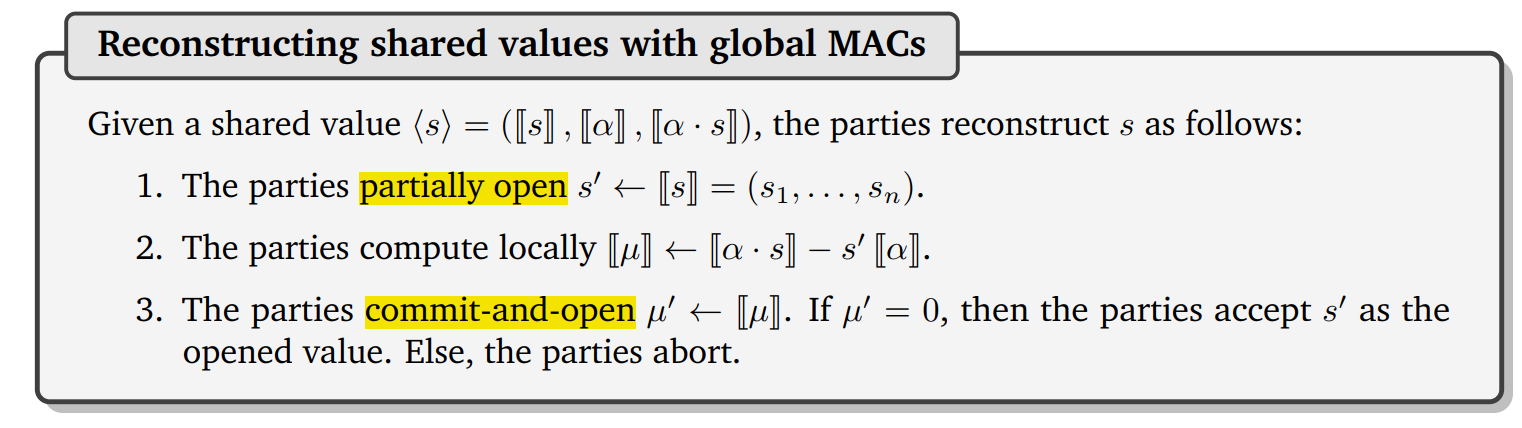

*Proposition*: If the protocol above does not result in abort, then each party outputs $s$ with probability at least $1 − 1/|F|$

Let $s^{\prime} = s + \delta$ and $\mu^{\prime} = \mu + \epsilon$ where $\delta$ and $\mu$ are modifications introduced by an adversary. Then

$$
\mu^{\prime} = \mu + \epsilon = (\alpha s - s^{\prime}\alpha) + \epsilon = \alpha s - (s+\delta)\alpha + \epsilon = \epsilon - \alpha \cdot \delta,
$$

so $\mu^{\prime} = 0$ if and only if $\epsilon - \alpha \cdot \delta = 0$ which is possible with probability $1/|F|$ because $\alpha$ is choosen randomly

#### Addition

Given two shared values $\langle x \rangle = (\mathbf x_1,..., \mathbf x_n)$ and $\langle y \rangle = (\mathbf y_1,...,\mathbf y_n)$ with $\mathbf x_i = (x_i, \alpha_i^{(x)}, \gamma_i^{(x)})$ and $\mathbf y_i = (y_i, \alpha_i^{(y)}, \gamma_i^{(y)})$ for $i \in [n]$ it is possible for the parties to obtain locally shares $\langle x+y \rangle$. This requires that $\alpha_i := \alpha_i^{(x)} = \alpha_i^{(y)}$, that is , the dealer samples $\alpha_1,...,\alpha_n \in_R \mathbb F$ once, and uses $\alpha=\sum\limits_{i=1}^n \alpha_i$ for all subsequent values. The shares $(\mathbf z_1,..., \mathbf z_n)$ are defined as $(\mathbf z_i = (z_i, \alpha_i, \gamma_i^{(z)})$ where 

$$
\begin{cases}
    z_i = x_i + y_i \\
    \gamma_i^{(z)} = \gamma_i^{(x)} + \gamma_i^{(y)}, i \in [n] \\
\end{cases}
$$

### Online Phase

Beaver tripple $(a,b,c)$ with $a \cdot b = c$ where $a,b \in_R \mathbb F$

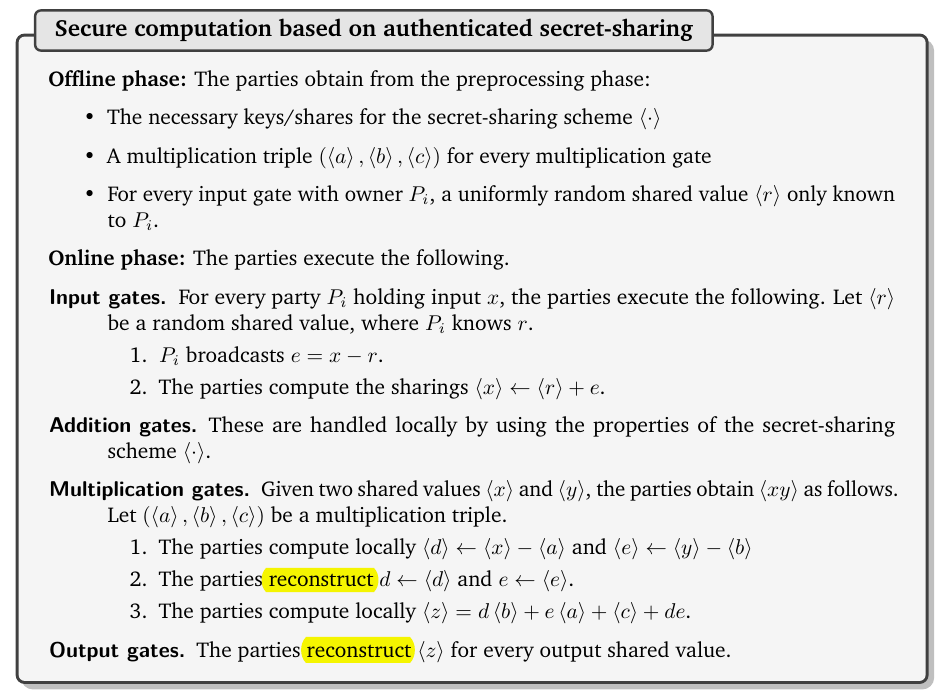

Most expensive part is reconstruction that has communication complexity $(n+1)^2$ (for pairwise MACs)

*Bibliography* : 

[1] A Pragmatic Introduction to Secure Multi-Party Computation, David Evans, Vladimir Kolesnikov and Mike Rosulek

[2] An introduction to Secret-Based Secure Multiparty Computation, Daniel Escudero, 2023